In [ ]:
import kagglehub
import os
import random
# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
path_work=os.path.join(path, 'kagglecatsanddogs_3367a', 'PetImages')
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1


In [ ]:
# Collect paths for Cat and Dog images
cat_images = []
dog_images = []

for root, dirs, files in os.walk(path_work):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        if 'Cat' in root:
            cat_images.append(file_path)
        elif 'Dog' in root:
            dog_images.append(file_path)

# Select 2 random images from each category
cat_sample = random.sample(cat_images, 2)
dog_sample = random.sample(dog_images, 2)

# Combine selected images
image_paths = cat_sample + dog_sample

In [ ]:
def list_image_filenames(dataset_path):
    """Lists image filenames with category (dog/cat) from the entire dataset."""
    image_filenames = []
    for category in ['Cat', 'Dog']:  # Iterate through both categories
        category_path = os.path.join(dataset_path, category)
        for _, _, files in os.walk(category_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_filenames.append(f"{category}({category.lower()})-{file}")
    return image_filenames

# Example usage
all_image_filenames = list_image_filenames(path_work)

# Print 5 filenames from each category:
print(f"Found {len(all_image_filenames)} image files.")
print("Cat filenames:")
for filename in all_image_filenames[:5]:  # First 5 are likely Cat
    print(filename)
print("\nDog filenames:")
dog_filenames = [f for f in all_image_filenames if f.startswith("Dog")]
for filename in dog_filenames[:5]:  # First 5 starting with "Dog"
    print(filename)

Found 24959 image files.
Cat filenames:
Cat(cat)-5325.jpg
Cat(cat)-6069.jpg
Cat(cat)-937.jpg
Cat(cat)-3001.jpg
Cat(cat)-3242.jpg

Dog filenames:
Dog(dog)-5325.jpg
Dog(dog)-6069.jpg
Dog(dog)-937.jpg
Dog(dog)-3001.jpg
Dog(dog)-8656.jpg


##Library definition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

##Resize images

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255   #normalize pixel values within the range of [0, 1] by dividing each pixel by 255.
    )
train = train_generator.flow_from_directory(
        directory=path_work,
        batch_size=32,
        target_size=(224,224)
    )

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
    )
test = test_generator.flow_from_directory(
        directory=path_work,
        batch_size=32,
        target_size=(224,224)
    )

imgs,y=next(train)

Found 24959 images belonging to 2 classes.
Found 24959 images belonging to 2 classes.


##Data visualization

In [ ]:
# Retrieve and display class indices from the training generator
class_indices = train.class_indices
print("Class indices:", class_indices)

# Invert the class_indices to map numerical labels to class names
inv_class_indices = {v: k for k, v in class_indices.items()}
print("Inverse class indices:", inv_class_indices)

Class indices: {'Cat': 0, 'Dog': 1}
Inverse class indices: {0: 'Cat', 1: 'Dog'}


##Model Architecture

In [ ]:
model = keras.Sequential([
    # Input Layer: Accepts images of shape (224, 224, 3)
    keras.Input(shape=(224, 224, 3)),

    # Convolutional Layers
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')  # Output layer for binary classification
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,545,986 (55.49 MB)

 Trainable params: 14,545,986 (55.49 MB)

 Non-trainable params: 0 (0.00 B)

##Training model

In [ ]:
# Compile mô hình
model.compile(
    optimizer="adam",
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Huấn luyện mô hình
history = model.fit(
    train,
    epochs=10,
    validation_data=test,
    validation_steps=5,
    verbose=1,
)

Epoch 1/10
326/780 ━━━━━━━━━━━━━━━━━━━━ 1:03 140ms/step - accuracy: 0.5129 - loss: 0.6953

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


729/780 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.5161 - loss: 0.6937

Class indices: {'Cat': 0, 'Dog': 1}
Class names ordered by index: ['Cat', 'Dog']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Image: 6638.jpg, Prediction: Cat (Cat: 1.00, Dog: 0.00)


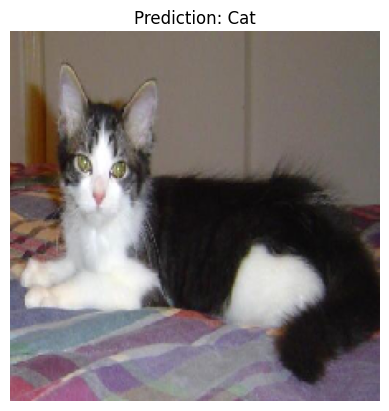

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: 6389.jpg, Prediction: Cat (Cat: 0.84, Dog: 0.16)


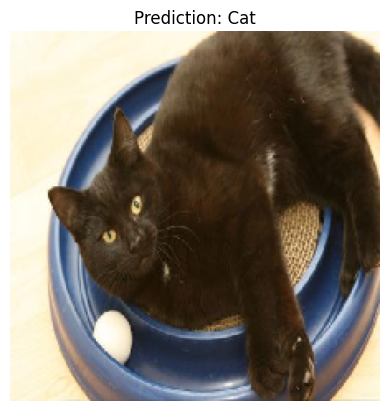

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: 94.jpg, Prediction: Dog (Cat: 0.00, Dog: 1.00)


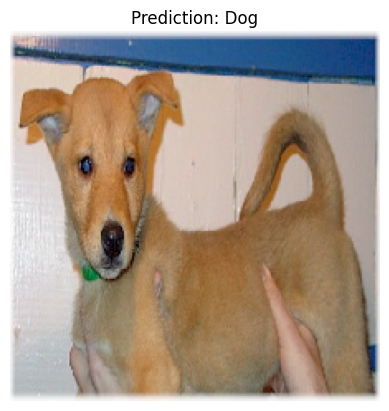

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: 9850.jpg, Prediction: Dog (Cat: 0.00, Dog: 1.00)


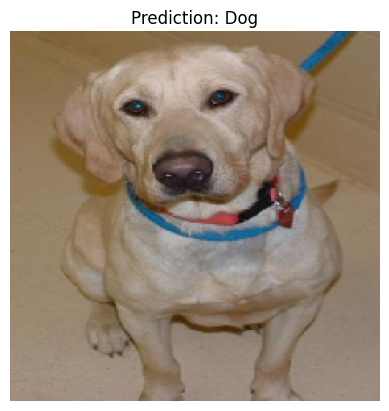

In [ ]:
class_indices = train.class_indices
print("Class indices:", class_indices)

# Create a list of class names ordered by their class indices
class_names = [None] * len(class_indices)
for class_name, index in class_indices.items():
    class_names[index] = class_name
print("Class names ordered by index:", class_names)
# Function to load and preprocess an image
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))  # Load the image with target size
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = img_array / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the model's input shape
    return img_array

# Iterate through the sample image paths and make predictions
for img_path in image_paths:
    processed_image = preprocess_image(img_path)
    prediction = model.predict(processed_image)
    cat_prob = prediction[0][class_indices['Cat']]
    dog_prob = prediction[0][class_indices['Dog']]
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_name = class_names[predicted_class]  # Map index to class name using the list

    # Print the prediction
    print(f"Image: {os.path.basename(img_path)}, Prediction: {class_name} (Cat: {cat_prob:.2f}, Dog: {dog_prob:.2f})")

    # Display the image with the prediction
    plt.figure()
    plt.imshow(load_img(img_path, target_size=(224, 224)))
    plt.title(f"Prediction: {class_name}")
    plt.axis('off')
    plt.show()


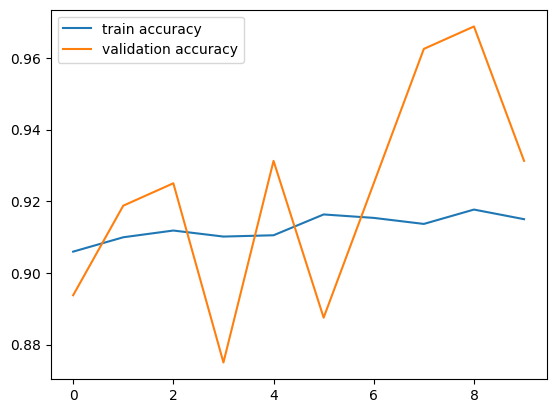

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()